In [1]:
import scvelo as scv
import numpy as np
from anndata import AnnData
# import loompy
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from scipy.cluster.hierarchy import fcluster,leaders
from sklearn.decomposition import PCA
from scipy.linalg import inv
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.mixture import GaussianMixture
from RKHS import SparseVFC
from RKHS import Jacobian_rkhs_gaussian
from scipy.stats import multivariate_normal


In [2]:
data_path='data/'
result_path='result/'
adata0=scv.read(data_path+'EG_ab_dyn.h5ad', cache=True)

In [3]:
#-------data preprocessing
adata=adata0.copy()
scv.pp.neighbors(adata, n_neighbors=20)
scv.pp.pca(adata,n_comps=50)
scv.pp.moments(adata, n_pcs=50, n_neighbors=20)

computing neighbors
    finished (0:00:10) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
Normalized count data: spliced, unspliced.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


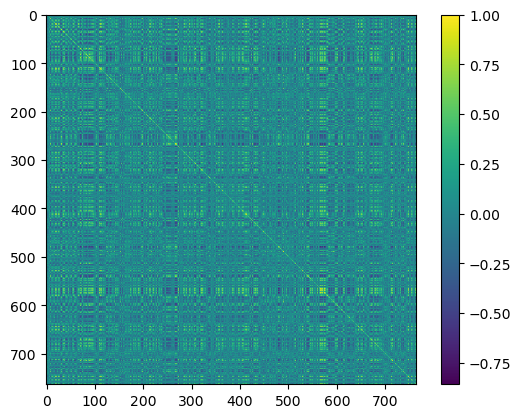

In [4]:
X0_ori=adata.layers['Ms']#adata.X.A#
scaler=StandardScaler()#MinMaxScaler(feature_range=(0,1))#
X=scaler.fit_transform(X0_ori)
X_corr=np.corrcoef(X, rowvar=False)
plt.imshow(X_corr)
plt.colorbar()
plt.show()

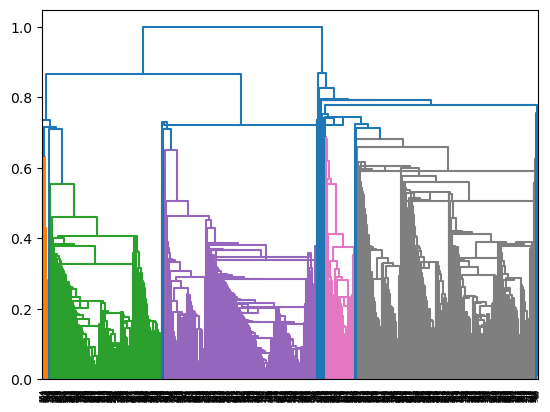

In [15]:
Z=linkage((1-X_corr)[np.triu_indices(X_corr.shape[0],k=1)],method='centroid')
dg=dendrogram(Z)
X_re= X[:,dg['leaves']]#X_re reorder X by clustering

In [6]:
n_com = 50
gmm = GaussianMixture(n_components=n_com, covariance_type='full')
gmm.fit(X_re)
cell_gmm_label = gmm.predict(X_re)

In [7]:
cell_pca=PCA(n_components=50).fit(X_re)
X_re_pc=cell_pca.transform(X_re)

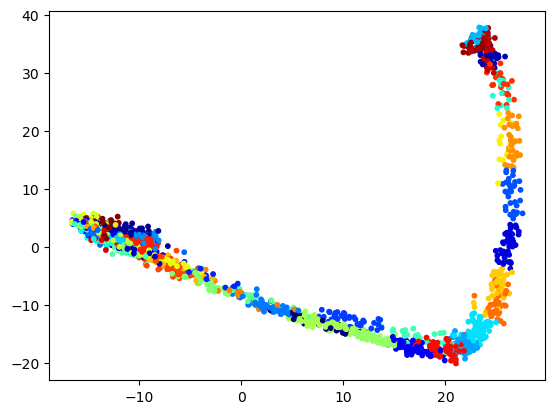

In [8]:
gmm.score(X_re)
gmm_mean=gmm.means_
# plt.scatter(-adata.obsm['X_pca'][:,0],adata.obsm['X_pca'][:,1],s=10,c=cell_gmm_label,cmap=plt.cm.jet)
plt.scatter(X_re_pc[:,0],X_re_pc[:,1],s=10,c=cell_gmm_label,cmap=plt.cm.jet)
plt.show()

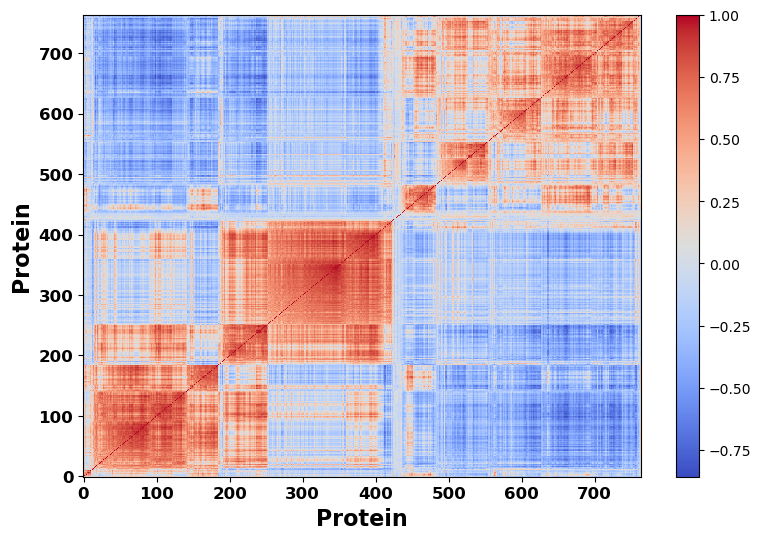

In [12]:
X_corr_re=np.corrcoef(X_re, rowvar=False)

plt.figure(figsize=(9,6))
plt.imshow(X_corr_re, aspect='auto', cmap=plt.cm.coolwarm, interpolation='nearest',origin='lower')

plt.xlabel('Protein',fontsize=16,fontweight='bold')
plt.ylabel('Protein',fontsize=16,fontweight='bold')

plt.xticks(fontsize=12,fontweight='bold')
plt.yticks(fontsize=12,fontweight='bold')
plt.colorbar()
# plt.savefig('heatmap_order.png',dpi=300)
plt.show()

In [13]:
# eigen gene is the value of first principal component of each community
def eigen_gene(X_re,T_re):#return the weights of each gene in correponding eigen gene
    eigen_X_w=[]
    for i in np.unique(T_re):
        pca=PCA(n_components=0.98).fit(X_re[:,T_re==i])
#         print(pca.explained_variance_ratio_)
        pc1=pca.transform(X_re[:,T_re==i])[:,0]
        eigen_X_w.append(pca.components_[0,:])
#         eigen_gene_size.append(np.where(T_re==i)[0].shape[0])
    return eigen_X_w

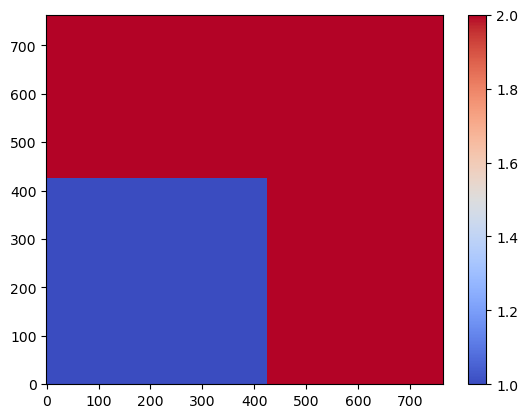

In [80]:
td=0.9
T=fcluster(Z, t=td, criterion='distance')

T_re=T[dg['leaves']]

X_corr_label=X_corr_re.copy()
for i in range(X_corr_re.shape[0]):
    X_corr_label[:,i]=T_re[i]
    X_corr_label[i,:]=T_re[i]

plt.imshow(X_corr_label, aspect='auto', cmap=plt.cm.coolwarm, interpolation='nearest',origin='lower')
plt.colorbar()
plt.show()

eigen_X_w=eigen_gene(X_re,T_re)
eigen_dim=len(np.unique(T_re))

gmm_eigen_X=np.zeros((gmm_mean.shape[0],eigen_dim))
for j in range(gmm_mean.shape[0]):
    for k in range(len(eigen_X_w)):
        gmm_eigen_X[j,k]=np.dot(eigen_X_w[k],gmm_mean[j,T_re==k+1])

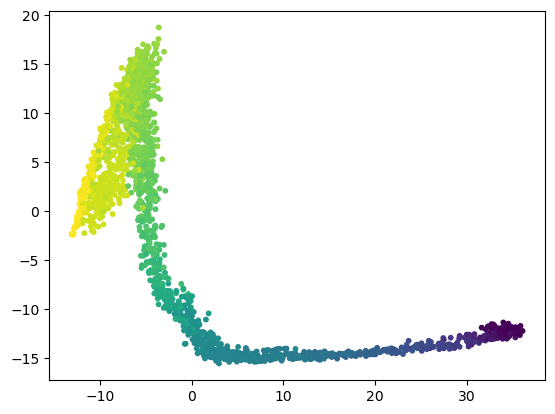

In [25]:
#---------eigen gene of each single cell----------------
cell_eigen_X=np.zeros((X_re.shape[0],eigen_dim))
for j in range(X_re.shape[0]):
    for k in range(len(eigen_X_w)):
        cell_eigen_X[j,k]=np.dot(eigen_X_w[k],X_re[j,T_re==k+1])

#plot eigen gene 
# fig= plt.figure(figsize=(6, 6))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(cell_eigen_X[:,0],cell_eigen_X[:,1],cell_eigen_X[:,2],s=10,c=adata.obs['velocity_pseudotime'])
# plt.show()

# plt.scatter(cell_eigen_X[:,0],cell_eigen_X[:,1],s=10,c=adata.obs['palantir_pseudotime'])
# plt.show()

# plt.scatter(cell_eigen_X[:,0],cell_eigen_X[:,2],s=10,c=adata.obs['velocity_pseudotime'])
# plt.show()

# plt.scatter(cell_eigen_X[:,1],cell_eigen_X[:,2],s=10,c=adata.obs['velocity_pseudotime'])
# plt.show()

In [119]:
vec_F=SparseVFC(gmm_eigen_X,gmm_mean,Grid=gmm_eigen_X)
#partial derivtive of Mu of each Gmm component with repect to each eigen gene
pMu_pEg=Jacobian_rkhs_gaussian(gmm_eigen_X, vec_F)

In [29]:
Fisher_g = np.array([pMu_pEg[:,:,l].transpose()@inv(gmm.covariances_[l])@pMu_pEg[:,:,l] for l in range(n_com)])

In [30]:
n = 10
print(Fisher_g[n])

[[4.40139177e-04 9.72660534e-05]
 [9.72660534e-05 2.19105049e-05]]


In [31]:
scv.tl.velocity(adata)
velo = np.array(adata.layers['velocity'])
velo_re= velo[:,dg['leaves']]

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [124]:
velo_ave = np.zeros([n_com, X_re.shape[1]])
for l in range(n_com):
    velo_ave[l] = np.sum(velo_re[cell_gmm_label==l], axis=0)
    velo_ave[l] /= velo_re[cell_gmm_label==l].shape[0]
    
v2 = np.array([velo_ave[l]@inv(gmm.covariances_[l])@velo_ave[l] for l in range(n_com)])
v1 = np.sqrt(v2)
cell_v_label = np.array([v1[cell_gmm_label[i]] for i in range(X_re.shape[0])])
    
zvelo_ave = np.zeros([n_com, eigen_dim])
for j in range(n_com):
    for k in range(len(eigen_X_w)):
        zvelo_ave[j,k]=np.dot(eigen_X_w[k],velo_ave[j,T_re==k+1])
        
zv2 = np.array([zvelo_ave[l]@Fisher_g[l]@zvelo_ave[l] for l in range(n_com)])
zv1 = np.sqrt(zv2)
cell_zv_label = np.array([zv1[cell_gmm_label[i]] for i in range(X_re.shape[0])])

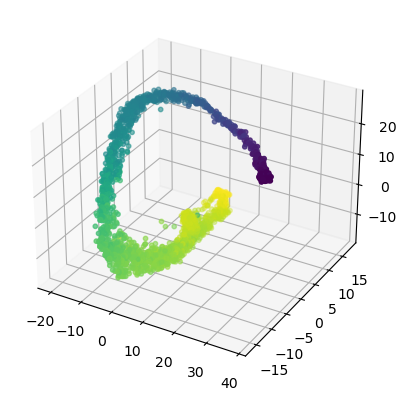

In [66]:
fig= plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(X_re_pc[:,1],X_re_pc[:,2],X_re_pc[:,0],s=10,c=adata.obs['palantir_pseudotime'])

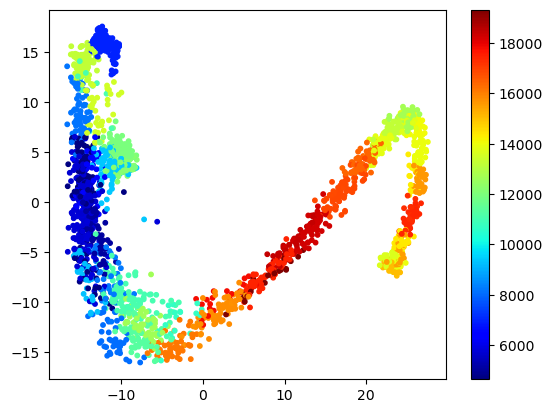

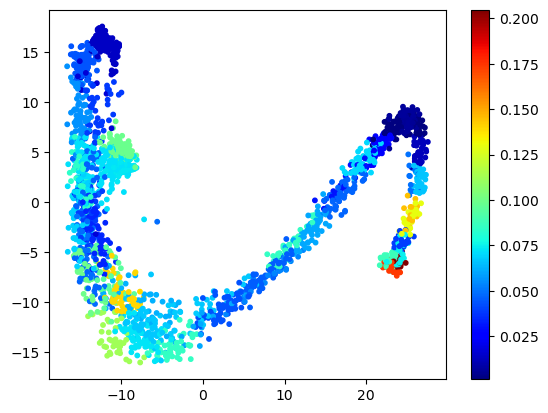

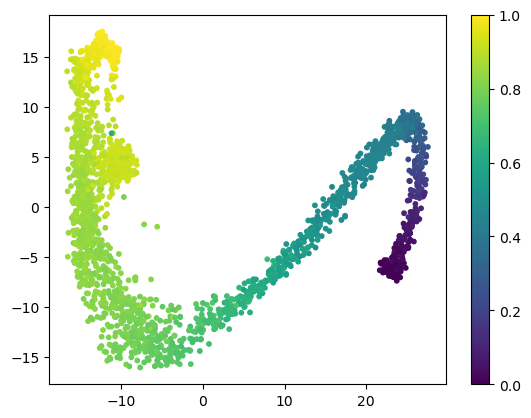

In [133]:
xpc = X_re_pc
xpc0 = xpc[:,0]
xpc1 = xpc[:,2]

plt.scatter(xpc0,xpc1,s=10,c=cell_v_label,cmap=plt.cm.jet)
plt.colorbar()
plt.show()

plt.scatter(xpc0,xpc1,s=10,c=cell_zv_label,cmap=plt.cm.jet)
plt.colorbar()
plt.show()

plt.scatter(xpc0,xpc1,s=10,c=adata.obs['palantir_pseudotime'])
plt.colorbar()
plt.show()

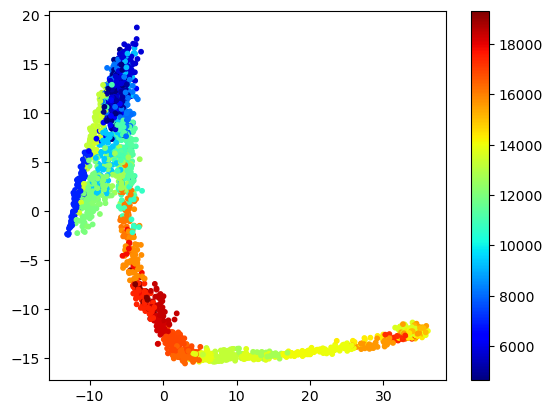

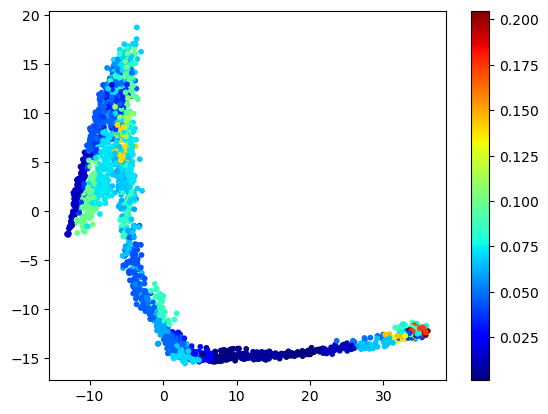

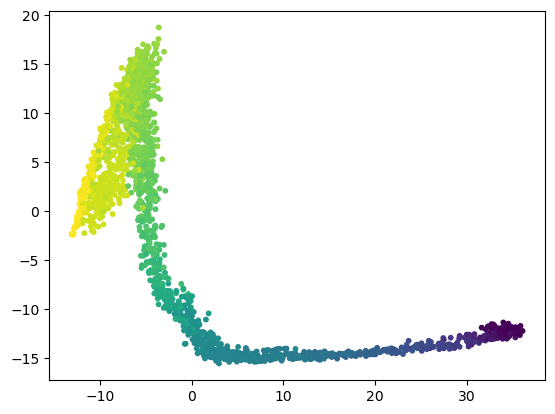

In [132]:
xpc = cell_eigen_X
xpc0 = xpc[:,0]
xpc1 = xpc[:,1]

plt.scatter(xpc0,xpc1,s=10,c=cell_v_label,cmap=plt.cm.jet)
plt.colorbar()
plt.show()

plt.scatter(xpc0,xpc1,s=10,c=cell_zv_label,cmap=plt.cm.jet)
plt.colorbar()
plt.show()

plt.scatter(xpc0,xpc1,s=10,c=adata.obs['palantir_pseudotime'])
plt.show()

In [120]:
wpupz = np.zeros([n_com,eigen_dim,eigen_dim])
for l in range(n_com):
    for i in range(eigen_dim):
        for j in range(eigen_dim):
            wpupz[l,i,j] = pMu_pEg[:,:,l].transpose()[i,T_re==j+1]@eigen_X_w[j]

In [121]:
wpupz[0]

array([[ 2.53517438e-06, -1.16054189e-05],
       [-5.06759024e-06,  8.77270416e-06]])